In [51]:
import pandas
import matplotlib
import seaborn
import collections
import igraph
import numpy

%matplotlib inline

matplotlib.rcParams['pdf.fonttype'] = matplotlib.rcParams['ps.fonttype'] = 42
seaborn.set_palette('colorblind')
seaborn.set_style('whitegrid')

In [52]:
import sys
sys.path.append('..')

from helpers import ECOSYSTEMS, DATE_RANGE, load_graph

In [53]:
FIG_SIZE = (6, 3)

In [54]:
graphs = collections.OrderedDict()

for ecosystem in ECOSYSTEMS:
    print(ecosystem, end=':')
    graphs[ecosystem] = collections.OrderedDict()
    
    for date in DATE_RANGE: 
        print('.', end='')
        graphs[ecosystem][date] = load_graph(ecosystem, date)
    
    print()

cran:..................................................................
npm:..................................................................
rubygems:..................................................................


## Graph size

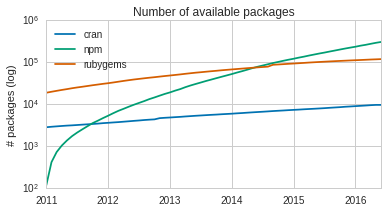

In [55]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        df.loc[date, ecosystem] = graph.vcount()
    
df.plot(ax=ax, logy=True)
    
ax.set(
    xlabel='', 
    ylabel='# packages (log)',
    title='Number of available packages',
)

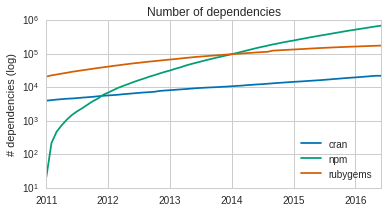

In [56]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        df.loc[date, ecosystem] =  graph.ecount()
    
df.plot(ax=ax, logy=True)
    
ax.set(
    xlabel='', 
    ylabel='# dependencies (log)',
    title='Number of dependencies',
)

## Graph density

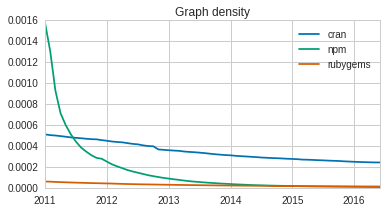

In [57]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        vs = graph.vcount()
        es = graph.ecount()
        df.loc[date, ecosystem] = (es) / (vs * (vs - 1))
    
df.plot(ax=ax)
    
ax.set(
    xlabel='', 
    ylabel='',
    title='Graph density',
)

## Number of transitive dependencies

[(0, 5),

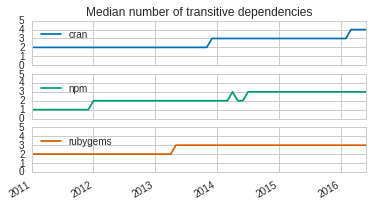

In [58]:
df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        df.loc[date, ecosystem] = numpy.median(graph.vs['tr-out'])
    
axes = df.plot(subplots=True, sharex=True, sharey=True)

axes[0].figure.set_size_inches(FIG_SIZE)
axes[0].set(
    xlabel='', 
    ylabel='',
    title='Median number of transitive dependencies',
    ylim=(0, 5),
)

## Isolated packages

[(0, 1),

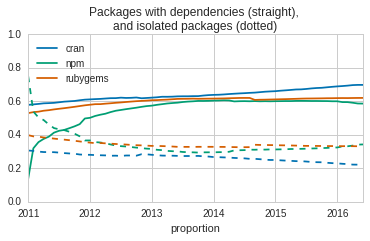

In [59]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)
df2 = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        with_deps = len(list(filter(lambda v: v['out'] > 0, graph.vs)))
        connected = len(list(filter(lambda v: v['in'] + v['out'] > 0, graph.vs)))
        
        df.loc[date, ecosystem] = with_deps / graph.vcount()
        df2.loc[date, ecosystem] = 1 - (connected / graph.vcount())
    
df.plot(ax=ax)
df2.plot(ax=ax, style='--', legend=False, color=seaborn.color_palette())

ax.set(
    xlabel='proportion', 
    ylabel='',
    title='Packages with dependencies (straight), \nand isolated packages (dotted)',
    ylim=(0, 1),
)

[(0, 1),

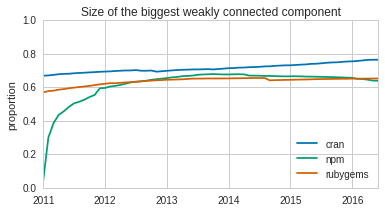

In [60]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        components = graph.components(mode=igraph.WEAK)
        df.loc[date, ecosystem] = components.giant().vcount() / graph.vcount()
    
df.plot(ax=ax)

ax.set(
    xlabel='', 
    ylabel='proportion',
    title='Size of the biggest weakly connected component',
    ylim=(0, 1),
)

## Relative impact

[(0, 0.5),

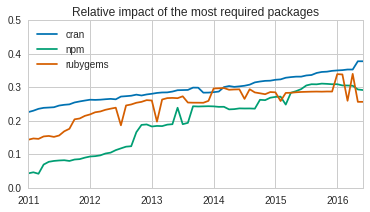

In [61]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        df.loc[date, ecosystem] = max(graph.vs['tr-in']) / graph.vcount()
    
df.plot(ax=ax)

ax.set(
    xlabel='', 
    ylabel='',
    title='Relative impact of the most required packages',
    ylim=(0, 0.5),
)

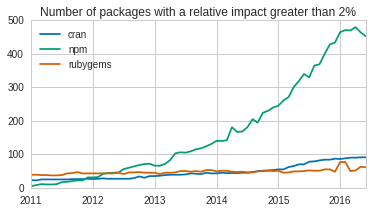

In [62]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

threshold = 2

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        p_threshold = graph.vcount() * threshold / 100
        df.loc[date, ecosystem] = len(list(filter(lambda v: v['tr-in'] >= p_threshold, graph.vs)))
    
df.plot(ax=ax)

ax.set(
    xlabel='', 
    ylabel='',
    title='Number of packages with a relative impact greater than {0}%'.format(threshold),
    
)

## Reusability metrics

In [63]:
def r_index(values):
    for i, d in enumerate(sorted(values, reverse=True)):
        if (i + 1) >= d:
            return d
    return 0

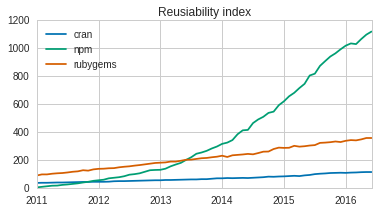

In [64]:
figure, ax = matplotlib.pyplot.subplots()
figure.set_size_inches(FIG_SIZE)

df = pandas.DataFrame(index=DATE_RANGE, columns=ECOSYSTEMS)

for ecosystem, dates in graphs.items():
    for date, graph in dates.items():
        df.loc[date, ecosystem] = r_index(graph.vs['tr-in'])
    
df.plot(ax=ax)

ax.set(
    xlabel='', 
    ylabel='',
    title='Reusiability index',
)